In [1]:
!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge folium --yes 
!conda install -c conda-forge pyquery --yes
!conda install -c conda-forge geocoder --yes

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'lxml')
wikitables = soup.find_all('table') 
Toronto = pd.read_html(str(wikitables[0]), index_col=None, header=0)[0]
Toronto.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [3]:
import requests
import numpy as np

In [4]:
# TO VERIFY THAT BOTH METHODS PRODUCE SIMILAR DIMENSIONS
Toronto.shape

(289, 3)

In [5]:
# Empty entries to np.nan to drop them in the next step
Toronto['Borough'].replace('', np.nan, inplace=True)
# Drop np.nan to remove rows not containing meaningful data
Toronto.dropna(subset=['Borough'], inplace=True)
# Leave behind rows containing 'Not assigned' in 'Borough'
Toronto = Toronto[Toronto['Borough'] != 'Not assigned']

In [6]:
# Iterate over the dataframe and fix 'Not assigned' for column 'Neighborhood'
for i, _ in Toronto.iterrows():
    if Toronto.loc[i]['Neighbourhood'] == 'Not assigned': Toronto.loc[i]['Neighborhood'] = Toronto.loc[i]['Borough']

In [7]:
# Check datafame shape
Toronto.shape

(212, 3)

In [8]:
# Print the number of rows in the dataframe
print('Number of rows in Toronto dataframe: {}'.format(Toronto.shape[0]))

Number of rows in Toronto dataframe: 212


In [9]:
TPS = Toronto['Postcode'].unique()
len(TPS)

103

In [10]:
!wget -q --no-check-certificate -O 'latitude.pickle' 'https://docs.google.com/uc?export=download&id=1PdEOkPErrpBtDgSlDwczIv_KLlpY-YcO'
!wget -q --no-check-certificate -O 'longitude.pickle' 'https://docs.google.com/uc?export=download&id=1XujA04dCARQnlxu-X2ItOVcYQz0MMQh9'

In [11]:
!ls -l *.pickle

-rw-rw-r-- 1 jupyterlab resources 1965 Dec  1 04:23 latitude.pickle
-rw-rw-r-- 1 jupyterlab resources 1965 Dec  1 04:23 longitude.pickle


In [12]:

import pickle

with open('latitude.pickle', 'rb') as flat:
    latitude = pickle.load(flat)
with open('longitude.pickle', 'rb') as flon:
    longitude = pickle.load(flon)

In [13]:
import geocoder
import time

for postcode in TPS:
    # When offline cache is available use it to avoid Geocoder Google API throttling
    if postcode in latitude.keys(): 
        continue
    while True:
        g = geocoder.google('{}, Toronto, Ontario'.format(postcode))
        lat_lng_coords = g.latlng
        if lat_lng_coords == None:
            print('Trottled response to {}'.format(postcode))
            time.sleep(5)
            continue
        break
    
    if lat_lng_coords != None:
        latitude[postcode] = lat_lng_coords[0]
        longitude[postcode] = lat_lng_coords[1]
print('Successfully populated geo locations')

Successfully populated geo locations


In [14]:
lat = []
lon = []
for i, _ in Toronto.iterrows():
    lat.append(latitude[Toronto.loc[i]['Postcode']])
    lon.append(longitude[Toronto.loc[i]['Postcode']])

In [15]:
Toronto = Toronto.assign(Latitude = lat, Longitude=lon)
Toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.753259,-79.329656
3,M4A,North York,Victoria Village,43.725882,-79.315572
4,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
5,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
6,M6A,North York,Lawrence Heights,43.718518,-79.464763


In [16]:

Toronto.shape

(212, 5)

In [17]:
Toronto = Toronto.reset_index(drop=True)
Toronto.to_csv('Toronto.csv')
Toronto.head(10)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763
5,M6A,North York,Lawrence Manor,43.718518,-79.464763
6,M7A,Queen's Park,Not assigned,43.662301,-79.389494
7,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
8,M1B,Scarborough,Rouge,43.806686,-79.194353
9,M1B,Scarborough,Malvern,43.806686,-79.194353


In [18]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [19]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

res = requests.get("https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods")
soup = BeautifulSoup(res.content,'lxml')
wikitables = soup.find_all('table') 
Toronto_Demographics = pd.read_html(str(wikitables[1]), index_col=None, header=0)[0]

In [20]:

Toronto_Demographics.head()

,Name,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map
0,Toronto CMA Average,NaN,All,5113149,5903.63,866,9.0,40704,10.6,11.4,NaN,NaN,NaN
1,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577,12.45,3580,4.6,25750,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,NaN
2,Alderwood,E,"0211.00, 0212.00",11656,4.94,2360,-4.0,35239,8.8,8.5,Polish (6.2%),06.2% Polish,NaN
3,Alexandra Park,OCoT,0039.00,4355,0.32,13609,0.0,19687,13.8,28.0,Cantonese (17.9%),17.9% Cantonese,NaN
4,Allenby,OCoT,0140.00,2513,0.58,4333,-1.0,245592,5.2,3.4,Russian (1.4%),01.4% Russian,NaN


In [21]:
df_dens = pd.DataFrame(Toronto_Demographics[['Name','Land area (km2)', 'Average Income', 'Density (people/km2)', 'Population', '% Change in Population since 2001']])
df_dens.drop([0], inplace=True)
df_dens.rename(columns={'% Change in Population since 2001': 'Change'}, inplace=True)
df_dens = df_dens.reset_index(drop=True)
df_dens.set_index(['Name'], inplace=True)
#df_dens.apply(pd.to_numeric, errors='ignore')
df_dens.head()

,Land area (km2),Average Income,Density (people/km2),Population,Change
Name,,,,,
Agincourt,12.45,25750,3580,44577,4.6
Alderwood,4.94,35239,2360,11656,-4.0
Alexandra Park,0.32,19687,13609,4355,0.0
Allenby,0.58,245592,4333,2513,-1.0
Amesbury,3.51,27546,4934,17318,1.1


In [22]:
df_dens['Change'] = df_dens['Change'].apply(lambda x: x * 1000)

<Figure size 432x288 with 0 Axes>

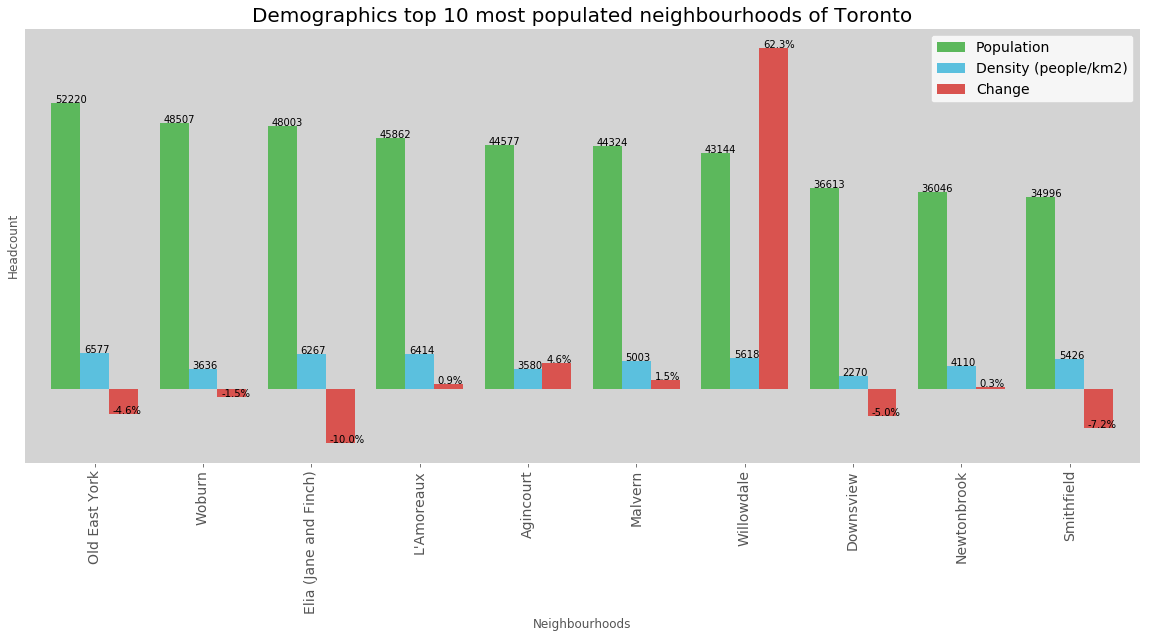

In [23]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use(['ggplot'])

fig = plt.figure()
ax = fig.add_subplot()
colors = ['#5cb85c', '#5bc0de', '#d9534f']
df_dens = df_dens.sort_values(['Population', 'Density (people/km2)'], ascending=False)
ax = df_dens[['Population', 'Density (people/km2)', 'Change']][:10].plot(kind='bar', grid=False, color=colors, figsize=(20, 8), legend=True, fontsize=14, width=0.8)
ax.set_facecolor('lightgray')
legend = plt.legend(frameon = 1, fontsize=14)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.yticks([])
plt.xlabel('Neighbourhoods')
plt.ylabel('Headcount')
plt.title('Demographics top 10 most populated neighbourhoods of Toronto', fontsize=20)
x_offset = -0.1
y_offset = 2
for n, p in enumerate(ax.patches):
    b = p.get_bbox()
    val = "{}".format(int(b.y1 + b.y0) if n <=19 else (b.y1 + b.y0)/1000)
    if n > 19:
        val += '%'
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.show()

In [24]:
import re
df_ai = pd.DataFrame(Toronto_Demographics[['Name','Average Income']])
df_ai.drop([0], inplace=True)
df_ai = df_ai.reset_index(drop=True)
df_ai.set_index(['Name'], inplace=True)
#df_dens.apply(pd.to_numeric, errors='ignore')
df_ai.head()
df_ai['Average Income'] = df_ai['Average Income'].apply(lambda x: 
                                                        (lambda match: 
                                                         int(match.group(1).replace(',','')) 
                                                         if match else 
                                                         int(x))(re.search(r'([\d\,]+)(Canada.*)', x)))
df_ai['Average Income'].dtype

dtype('int64')

In [25]:
df_ai['Average Income'].values

array([ 25750,  35239,  19687, 245592,  27546, 116651,  92319,  34169,
        40598,  46752,  41485,  80827,  29723,  48965,  55578,  41605,
        27156, 314107,  27260,  50398, 103703,  23301,  82203,  34867,
        81288,  30556,  37653,  26610,  33392,  38182,  32701,  54681,
        23021, 104362,  28335,  55735,  80704,  41998,  40617,  47515,
        30442,  26525,  28311,  26751,  27961,  26672,  33847,  36206,
        25307,  22691,  34789,  28403,  63282,  63952,  23471, 101631,
        46086,  37614,  35022, 129904,  35277,  23350,  40806,  45792,
        69232,  22136,  56395,  46437,  33640,  33465, 222560,  39186,
        39738,  26117,  80618,  30907,  24297,  29576,  40404,  25078,
        43570,  28067,  23335,  32004,  30920,  26375,  46631,  29867,
        36361, 214110,  82670,  83853,  30886,  31231,  29224,  37288,
       127356,  25677,  27611,  51695,  30944,  25243,  47011, 154825,
        27139,  23910,  33415,  33428,  44611,  34330,  21155,  33517,
      

<Figure size 432x288 with 0 Axes>

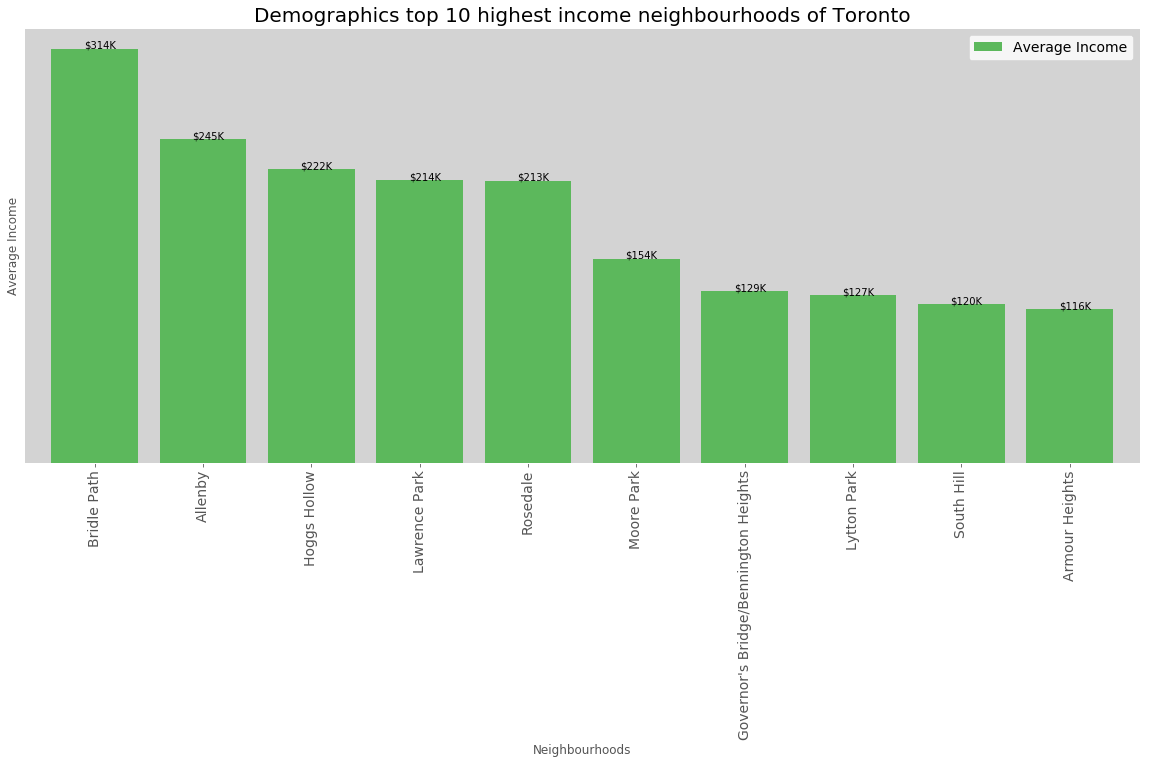

In [26]:

mpl.style.use(['ggplot'])

fig = plt.figure()
ax = fig.add_subplot()
colors = ['#5cb85c']
df_ai = df_ai.sort_values(['Average Income'], ascending=False)
ax = df_ai[['Average Income']][:10].plot(kind='bar', grid=False, color=colors, figsize=(20, 8), legend=True, fontsize=14, width=0.8)
ax.set_facecolor('lightgray')
legend = plt.legend(frameon = 1, fontsize=14)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.yticks([])
plt.xlabel('Neighbourhoods')
plt.ylabel('Average Income')
plt.title('Demographics top 10 highest income neighbourhoods of Toronto', fontsize=20)
x_offset = -0.1
y_offset = 2
for n, p in enumerate(ax.patches):
    b = p.get_bbox()
    val = "${}K".format(int((b.y1 + b.y0)/1000))
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.show()

Text(0.5,1,'Average Income 10 top neighbourhoods in the city of Toronto')

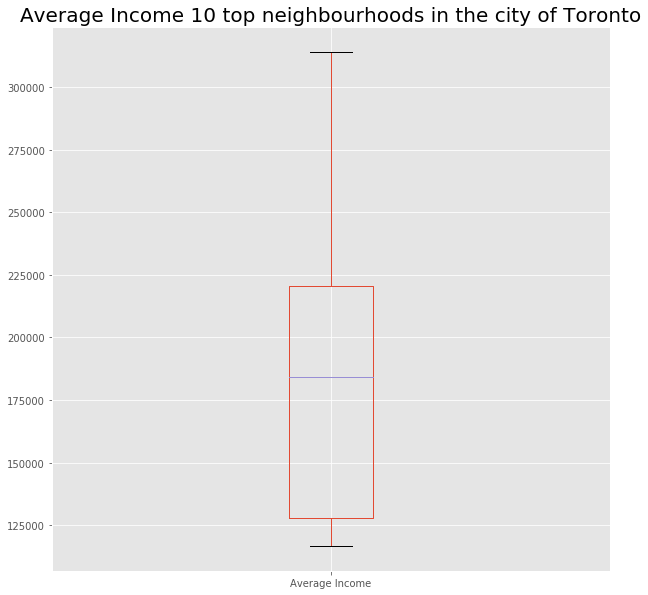

In [27]:
df_ai[['Average Income']][:10].plot.box(figsize=(10,10))
plt.title('Average Income 10 top neighbourhoods in the city of Toronto', fontsize=20)

Text(0.5,1,'Average Income - Toronto')

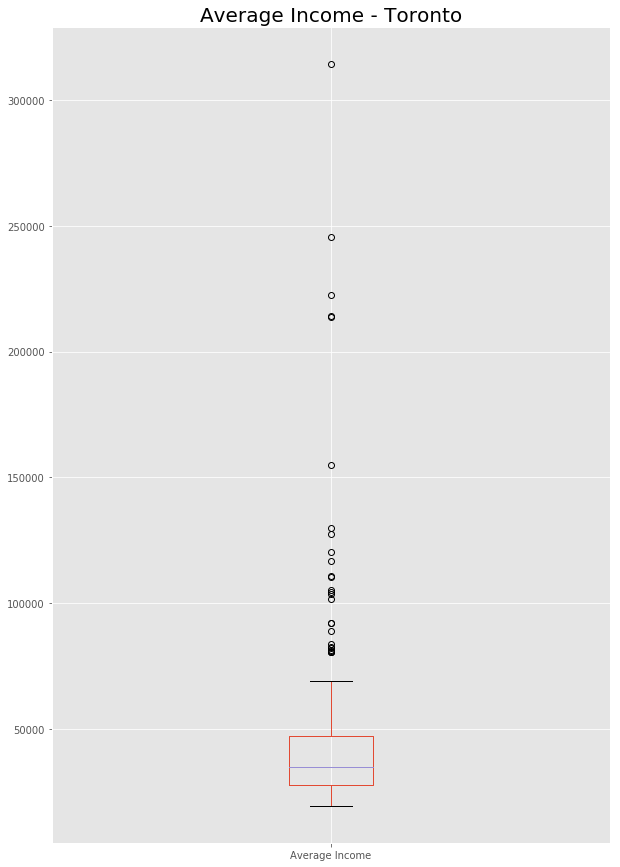

In [28]:
df_ai.plot.box(figsize=(10, 15))
plt.title('Average Income - Toronto', fontsize=20)

In [29]:
import re
df_ip = pd.DataFrame(Toronto_Demographics[['Average Income', 'Population']])
df_ip.drop([0], inplace=True)
#df_ip = df_ai.reset_index(drop=True)
#df_ai.set_index(['Name'], inplace=True)
#df_dens.apply(pd.to_numeric, errors='ignore')
df_ip.head()
df_ip['Average Income'] = df_ip['Average Income'].apply(lambda x: 
                                                        (lambda match: 
                                                         int(match.group(1).replace(',','')) 
                                                         if match else 
                                                         int(x))(re.search(r'([\d\,]+)(Canada.*)', x)))
df_ip['Population'] = df_ip['Population'].apply(lambda x: int(x))
df_ip = df_ip.sort_values(['Population'])
df_ip = df_ip.reset_index(drop=True)
df_ip

,Average Income,Population
0,63952,548
1,36243,571
2,43344,627
3,314107,1540
4,129904,2112
5,245592,2513
6,36652,2719
7,56395,2790
8,222560,3123
9,22136,3375


Text(0.5,1,'Average Income - Population in the city of Toronto')

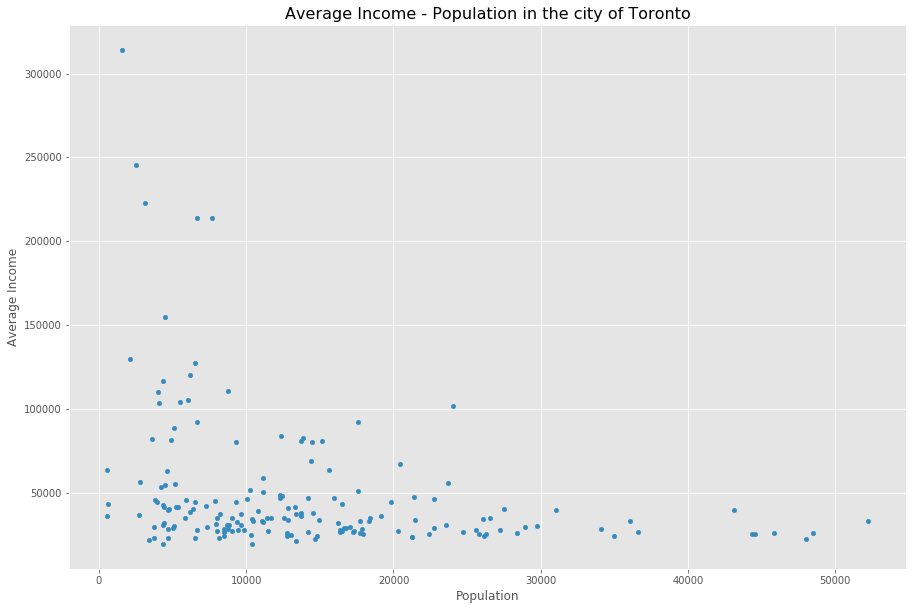

In [30]:
df_ip.plot.scatter(x='Population', y='Average Income', figsize=(15,10))
plt.title('Average Income - Population in the city of Toronto', fontsize=16)

In [31]:
columns_to_drop = [
    'FM', 
    'Census Tracts', 
    '% Change in Population since 2001', 
    'Land area (km2)', 
    'Transit Commuting\xa0%', 
    '% Renters', 
    'Second most common language (after English) by name', 
    'Map'
]

Toronto_Demographics.drop(columns=columns_to_drop, inplace=True)

Toronto_Demographics = Toronto_Demographics.rename(columns={'Second most common language (after English) by percentage':'ESL'})
Toronto_Demographics = Toronto_Demographics.rename(columns={'Name':'Neighbourhood'})
Toronto_Demographics.drop([0], inplace=True)

Toronto_Demographics.head()
Toronto_Demographics['Percentage'] = Toronto_Demographics.apply (lambda row: row['ESL'].split('% ')[0],axis=1)
Toronto_Demographics['Language'] = Toronto_Demographics.apply (lambda row: row['ESL'].split('% ')[1],axis=1)
Toronto_Demographics.drop(columns=['ESL'], inplace=True)

In [32]:

Toronto_Demographics.head(10)

,Neighbourhood,Population,Density (people/km2),Average Income,Percentage,Language
1,Agincourt,44577,3580,25750,19.3,Cantonese
2,Alderwood,11656,2360,35239,06.2,Polish
3,Alexandra Park,4355,13609,19687,17.9,Cantonese
4,Allenby,2513,4333,245592,01.4,Russian
5,Amesbury,17318,4934,27546,06.1,Spanish
6,Armour Heights,4384,1914,116651,09.4,Russian
7,Banbury,6641,2442,92319,05.1,Unspecified Chinese
8,Bathurst Manor,14945,3187,34169,09.5,Russian
9,Bay Street Corridor,4787,43518,40598,09.6,Mandarin
10,Bayview Village,12280,2966,46752,08.4,Cantonese


In [33]:
Toronto_Demographics.describe()

,Population,Density (people/km2)
count,174.000000,174.000000
mean,13883.758621,6227.752874
std,10319.218850,6772.093019
min,548.000000,94.000000
25%,6258.000000,3123.250000
50%,11279.000000,4934.500000
75%,17705.500000,7580.000000
max,52220.000000,63765.000000


In [34]:
Toronto_Demographics.shape

(174, 6)

In [35]:
df1 = pd.DataFrame(Toronto_Demographics[Toronto_Demographics['Language'].isin(['Filipino'])])
df1.reset_index(drop=True)
df1 = df1.set_index(['Neighbourhood'])
df1

,Population,Density (people/km2),Average Income,Percentage,Language
Neighbourhood,,,,,
Clairlea,11104,3102,33392,04.3,Filipino
Cricket Club,5504,2808,104362,01.4,Filipino
Ionview,13025,6714,25078,06.5,Filipino
Lawrence Manor,13750,6425,36361,07.2,Filipino
Ledbury Park,12360,4944,83853,01.4,Filipino
Maryvale,8800,3860,30944,04.1,Filipino
Port Union,12450,2310,48117,01.6,Filipino
Rouge Hill,11167,2878,32858,02.4,Filipino
St. James Town,14666,63765,22341,08.1,Filipino


In [36]:
df_td_fi = pd.DataFrame(Toronto_Demographics[Toronto_Demographics['Language'].isin(['Filipino'])])
df_td_fi.reset_index(drop=True)
df_td_fi = df_td_fi.set_index(['Neighbourhood'])
df_td_fi['Percentage'] = df_td_fi['Percentage'].apply(lambda x: float(x))
df_td_fi['Average Income'] = df_td_fi['Average Income'].apply(lambda x: 
                                                        (lambda match: 
                                                         int(match.group(1).replace(',','')) 
                                                         if match else 
                                                         int(x))(re.search(r'([\d\,]+)(Canada.*)', x)))
df_td_fi['Population'] = df_td_fi['Population'].apply(lambda x: int(x))
df_td_fi['FIL'] = df_td_fi.apply(lambda x: int(x['Population'] * x['Percentage'] / 100), axis=1)
df_td_fi = df_td_fi.sort_values(['FIL'], ascending=False)
df_td_fi = df_td_fi.reset_index()
# df_td_fi = df_td_fi.set_index(['Neighbourhood'])
df_td_fi = df_td_fi.set_index(['Neighbourhood'])
df_td_fi

,Population,Density (people/km2),Average Income,Percentage,Language,FIL
Neighbourhood,,,,,,
St. James Town,14666,63765,22341,8.1,Filipino,1187
Lawrence Manor,13750,6425,36361,7.2,Filipino,990
Wilson Heights,13732,3317,37978,6.2,Filipino,851
Ionview,13025,6714,25078,6.5,Filipino,846
Wexford,17844,2239,28556,4.5,Filipino,802
Clairlea,11104,3102,33392,4.3,Filipino,477
Maryvale,8800,3860,30944,4.1,Filipino,360
Rouge Hill,11167,2878,32858,2.4,Filipino,268
Port Union,12450,2310,48117,1.6,Filipino,199


<Figure size 432x288 with 0 Axes>

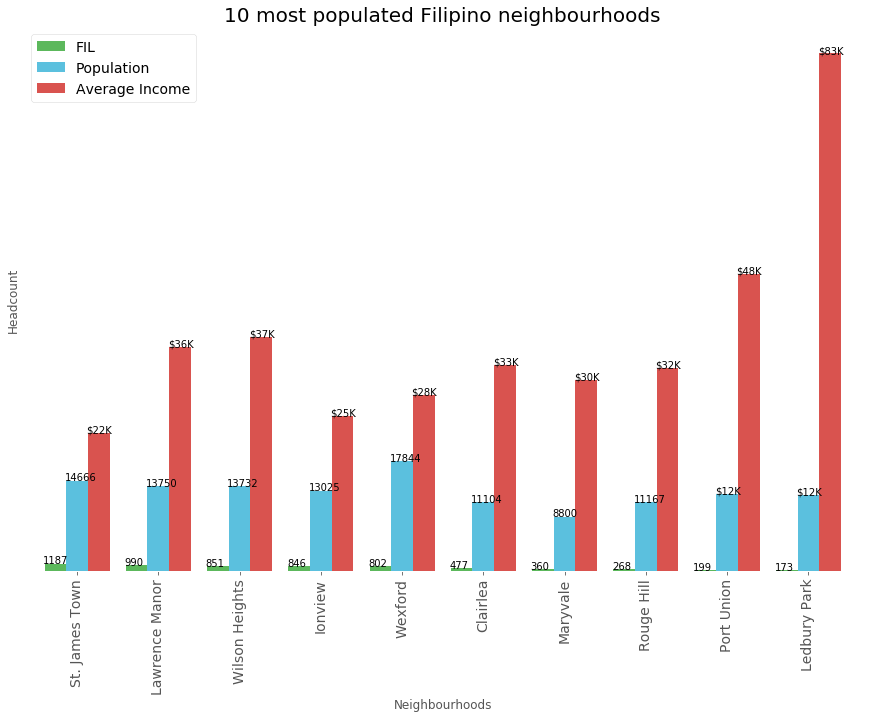

In [37]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use(['ggplot'])

fig = plt.figure()
ax = fig.add_subplot()
colors = ['#5cb85c', '#5bc0de', '#d9534f']
df_dens = df_td_fi
# df_dens['Average Income'] = df_dens['Average Income'].apply(lambda x: int(x/10))
ax = df_dens[['FIL', 'Population', 'Average Income']][:10].plot(kind='bar', grid=False, color=colors, figsize=(15, 10), legend=True, fontsize=14, width=0.8)
ax.set_facecolor('white')
legend = plt.legend(frameon = 1, fontsize=14)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.yticks([])
plt.xlabel('Neighbourhoods')
plt.ylabel('Headcount')
plt.title('10 most populated Filipino neighbourhoods', fontsize=20)
x_offset = -0.15
y_offset = 2
for n, p in enumerate(ax.patches):
    b = p.get_bbox()
    val = "{}".format(int(b.y1 + b.y0) if n <=17 else '$' + str(int((b.y1+b.y0)/1000))+'K')
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.show()

Text(0.5,1,'Filipino Population Average Income - Toronto')

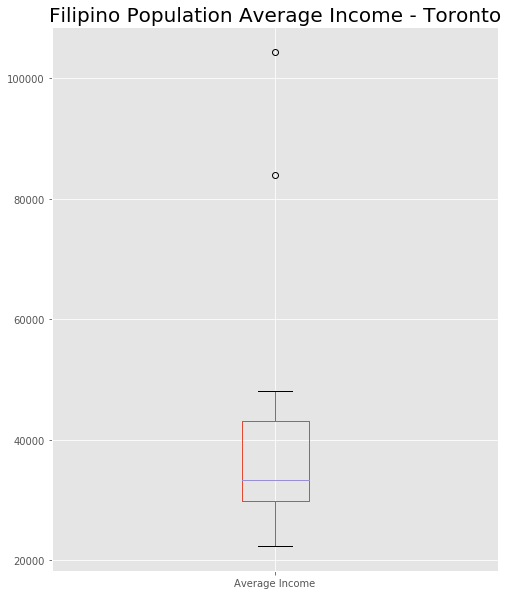

In [38]:
fi_avg_inc = df_td_fi[['Average Income']]
fi_avg_inc.plot.box(figsize=(8, 10))
plt.title('Filipino Population Average Income - Toronto', fontsize=20)

Text(0.5,1,'Filipino Population Average Income - Population in the city of Toronto')

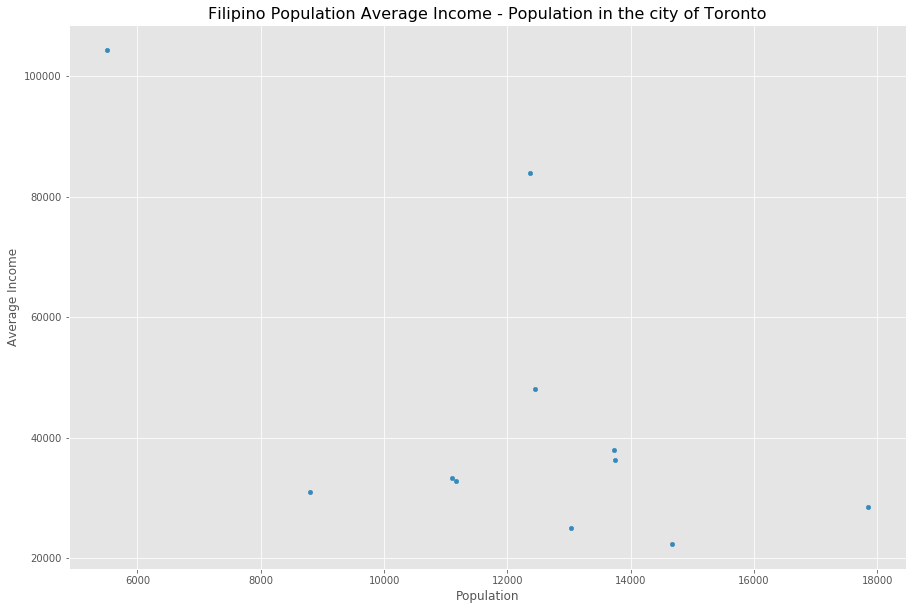

In [39]:
fi_avg = df_td_fi[['Population', 'Average Income']]
fi_avg.plot.scatter(x='Population', y='Average Income', figsize=(15,10))
plt.title('Filipino Population Average Income - Population in the city of Toronto', fontsize=16)

<Figure size 432x288 with 0 Axes>

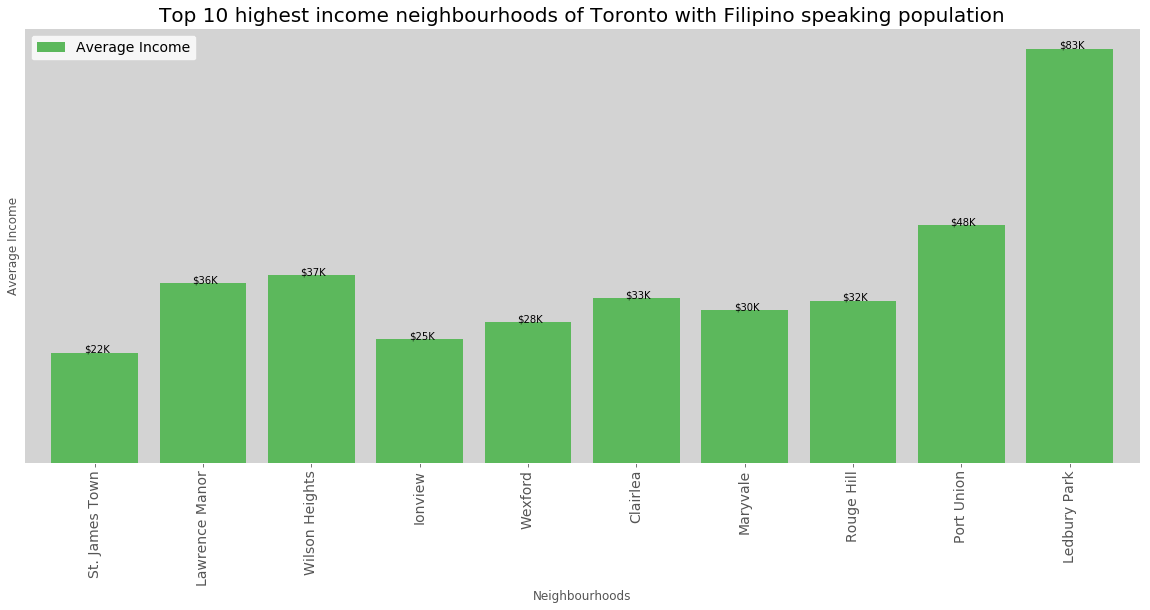

In [40]:
mpl.style.use(['ggplot'])

fig = plt.figure()
ax = fig.add_subplot()
colors = ['#5cb85c']
df_avg = fi_avg.sort_values(['Average Income'], ascending=False)
ax = fi_avg[['Average Income']][:10].plot(kind='bar', grid=False, color=colors, figsize=(20, 8), legend=True, fontsize=14, width=0.8)
ax.set_facecolor('lightgray')
legend = plt.legend(frameon = 1, fontsize=14)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.yticks([])
plt.xlabel('Neighbourhoods')
plt.ylabel('Average Income')
plt.title('Top 10 highest income neighbourhoods of Toronto with Filipino speaking population', fontsize=20)
x_offset = -0.1
y_offset = 2
for n, p in enumerate(ax.patches):
    b = p.get_bbox()
    val = "${}K".format(int((b.y1 + b.y0)/1000))
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.show()

In [41]:

list_of_neighbourhoods = Toronto_Demographics['Neighbourhood'].values.tolist()

In [42]:

Toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


In [43]:
list_missing_neigh = []
for neigh in list_of_neighbourhoods:
    if neigh not in Toronto['Neighbourhood'].values and neigh not in Toronto['Borough']:
        list_missing_neigh.append(neigh)
list_missing_neigh

['Alexandra Park',
 'Allenby',
 'Amesbury',
 'Armour Heights',
 'Banbury',
 'Bay Street Corridor',
 'Bayview Woods – Steeles',
 'Bendale',
 'Bloor West Village',
 'Bracondale Hill',
 'Branson',
 'Bridle Path',
 'Caribou Park',
 'Carleton Village',
 'Casa Loma',
 'Centennial',
 'Chaplin Estates',
 'Christie Pits',
 'Clairville',
 'Corktown',
 'Crescent Town',
 'Cricket Club',
 'Davenport',
 'Discovery District',
 'Distillery District/West Don Lands',
 'Don Mills',
 'Don Valley Village',
 'Dovercourt Park',
 'Downsview',
 'Dufferin Grove',
 'Earlscourt',
 'East Danforth',
 'Eatonville',
 'Eglinton East',
 'Elia (Jane and Finch)',
 'Fairbank',
 'Fashion District',
 'Financial District',
 'Forest Hill',
 'Fort York/Liberty Village',
 'Glen Park',
 "Governor's Bridge/Bennington Heights",
 'Graydon Hall',
 'Harbord Village',
 'Harbourfront / CityPlace',
 'Harwood',
 'High Park North',
 'Hillcrest',
 'Hoggs Hollow',
 'Humber Heights',
 'Humber Valley Village',
 'Humbermede',
 'Humberwood',
 '

In [44]:
Toronto_Demographics = Toronto_Demographics[~Toronto_Demographics.Neighbourhood.isin(list_missing_neigh)]

In [45]:

Toronto_Demographics.reset_index(drop=True)

,Neighbourhood,Population,Density (people/km2),Average Income,Percentage,Language
0,Agincourt,44577,3580,25750,19.3,Cantonese
1,Alderwood,11656,2360,35239,06.2,Polish
2,Bathurst Manor,14945,3187,34169,09.5,Russian
3,Bayview Village,12280,2966,46752,08.4,Cantonese
4,Bedford Park,13749,6057,80827,00.7,Greek
5,Birch Cliff,12266,3525,48965,00.9,Unspecified Chinese
6,Brockton,9039,8217,27260,19.9,Portuguese
7,Cabbagetown,11120,7943,50398,01.6,Unspecified Chinese
8,Church and Wellesley,13397,24358,37653,01.8,Spanish
9,Clairlea,11104,3102,33392,04.3,Filipino


In [46]:
list_exist_neigh_dem = Toronto_Demographics['Neighbourhood'].values.tolist()

In [47]:
Toronto = Toronto[Toronto.Neighbourhood.isin(list_exist_neigh_dem)]
Toronto.reset_index(drop=True)
Toronto.shape

(79, 5)

In [48]:
Toronto_Demographics.shape

(77, 6)

In [49]:
Toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
4,M6A,North York,Lawrence Heights,43.718518,-79.464763
5,M6A,North York,Lawrence Manor,43.718518,-79.464763
8,M1B,Scarborough,Rouge,43.806686,-79.194353


In [50]:
Toronto_Merged = pd.merge(Toronto, Toronto_Demographics, on='Neighbourhood')

In [51]:
Toronto_Merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Percentage,Language
0,M3A,North York,Parkwoods,43.753259,-79.329656,26533,5349,34811,03.4,Unspecified Chinese
1,M4A,North York,Victoria Village,43.725882,-79.315572,17047,3612,29657,03.2,Urdu
2,M6A,North York,Lawrence Heights,43.718518,-79.464763,3769,1178,29867,15.0,Italian
3,M6A,North York,Lawrence Manor,43.718518,-79.464763,13750,6425,36361,07.2,Filipino
4,M1B,Scarborough,Rouge,43.806686,-79.194353,22724,791,29230,15.6,Tamil


In [52]:
Toronto_Merged.drop_duplicates(keep='first', inplace=True)

In [53]:
address = 'Toronto, Ontario'

geolocator = Nominatim()
location = geolocator.geocode(address)
T_lat = location.latitude
T_lon = location.longitude
print('The geograpical coordinate of Toronto, ON, Canada are {}, {}.'.format(T_lat, T_lon))

/home/jupyterlab/conda/lib/python3.6/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Toronto, ON, Canada are 43.653963, -79.387207.


In [54]:
T_map = folium.Map(location=[T_lat, T_lon], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto['Latitude'], Toronto['Longitude'], Toronto['Borough'], Toronto['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(T_map)  
    
T_map

In [55]:
CLIENT_ID = '23DB3QXW1DBU3D4DZSWG02LAG0JHJ1V010GUOPGP1WO3OXTR'
CLIENT_SECRET = 'QWGHM2RUOI4NGXHBWM2FBAMQYAANHMRL5B0RBEX1YFDNHLMZ'
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 23DB3QXW1DBU3D4DZSWG02LAG0JHJ1V010GUOPGP1WO3OXTR
CLIENT_SECRET:QWGHM2RUOI4NGXHBWM2FBAMQYAANHMRL5B0RBEX1YFDNHLMZ


In [56]:
df_fil = Toronto_Merged[Toronto_Merged.Language.isin(['Filipino'])]
df_fil = df_fil.sort_values(by=['Percentage','Population'], ascending=False)
df_fil.reset_index(drop=True)

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Percentage,Language
0,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,14666,63765,22341,08.1,Filipino
1,M4X,Downtown Toronto,St. James Town,43.667967,-79.367675,14666,63765,22341,08.1,Filipino
2,M6A,North York,Lawrence Manor,43.718518,-79.464763,13750,6425,36361,07.2,Filipino
3,M1K,Scarborough,Ionview,43.727929,-79.262029,13025,6714,25078,06.5,Filipino
4,M3H,North York,Wilson Heights,43.754328,-79.442259,13732,3317,37978,06.2,Filipino
5,M1R,Scarborough,Wexford,43.750071,-79.295849,17844,2239,28556,04.5,Filipino
6,M1L,Scarborough,Clairlea,43.711112,-79.284577,11104,3102,33392,04.3,Filipino
7,M1R,Scarborough,Maryvale,43.750071,-79.295849,8800,3860,30944,04.1,Filipino
8,M1C,Scarborough,Rouge Hill,43.784535,-79.160497,11167,2878,32858,02.4,Filipino
9,M1C,Scarborough,Port Union,43.784535,-79.160497,12450,2310,48117,01.6,Filipino


In [57]:
T_map = folium.Map(location=[T_lat, T_lon], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_fil['Latitude'], df_fil['Longitude'], df_fil['Borough'], df_fil['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(T_map)  
    
T_map

In [58]:
fil_lat = df_fil['Latitude'].values[0] # neighborhood latitude value
fil_lon = df_fil['Longitude'].values[0] # neighborhood longitude value
fil_name = df_fil['Neighbourhood'].values[0] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(fil_name, 
                                                               fil_lat, 
                                                               fil_lon))

Latitude and longitude values of St. James Town are 43.6514939, -79.3754179.


In [59]:
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    fil_lat, 
    fil_lon, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=23DB3QXW1DBU3D4DZSWG02LAG0JHJ1V010GUOPGP1WO3OXTR&client_secret=QWGHM2RUOI4NGXHBWM2FBAMQYAANHMRL5B0RBEX1YFDNHLMZ&v=20180605&ll=43.6514939,-79.3754179&radius=500&limit=100'

In [60]:
results = requests.get(url).json()
# results
if results != None:
    print("Request successfully processed")

Request successfully processed


In [61]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [62]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Terroni,Italian Restaurant,43.650927,-79.375602
1,Gyu-Kaku Japanese BBQ,Japanese Restaurant,43.651422,-79.375047
2,GEORGE Restaurant,Restaurant,43.653346,-79.374445
3,Fahrenheit Coffee,Coffee Shop,43.652384,-79.372719
4,Triple A Bar (AAA),BBQ Joint,43.651658,-79.372720


In [63]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [64]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [65]:
# type your answer here
fil_venues = getNearbyVenues(names=df_fil['Neighbourhood'],
                                   latitudes=df_fil['Latitude'],
                                   longitudes=df_fil['Longitude']
                                  )

St. James Town
St. James Town
Lawrence Manor
Ionview
Wilson Heights
Wexford
Clairlea
Maryvale
Rouge Hill
Port Union


In [66]:
print(fil_venues.shape)
fil_venues.head()

(212, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,St. James Town,43.651494,-79.375418,Terroni,43.650927,-79.375602,Italian Restaurant
1,St. James Town,43.651494,-79.375418,Gyu-Kaku Japanese BBQ,43.651422,-79.375047,Japanese Restaurant
2,St. James Town,43.651494,-79.375418,GEORGE Restaurant,43.653346,-79.374445,Restaurant
3,St. James Town,43.651494,-79.375418,Fahrenheit Coffee,43.652384,-79.372719,Coffee Shop
4,St. James Town,43.651494,-79.375418,Triple A Bar (AAA),43.651658,-79.372720,BBQ Joint


In [139]:
fil_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,St. James Town,43.651494,-79.375418,Terroni,43.650927,-79.375602,Italian Restaurant
1,St. James Town,43.651494,-79.375418,Gyu-Kaku Japanese BBQ,43.651422,-79.375047,Japanese Restaurant
2,St. James Town,43.651494,-79.375418,GEORGE Restaurant,43.653346,-79.374445,Restaurant
3,St. James Town,43.651494,-79.375418,Fahrenheit Coffee,43.652384,-79.372719,Coffee Shop
4,St. James Town,43.651494,-79.375418,Triple A Bar (AAA),43.651658,-79.372720,BBQ Joint
5,St. James Town,43.651494,-79.375418,Pearl Diver,43.651481,-79.373600,Gastropub
6,St. James Town,43.651494,-79.375418,Aveda Institute Toronto,43.650096,-79.373630,Cosmetics Shop
7,St. James Town,43.651494,-79.375418,Crepe TO,43.650063,-79.374587,Creperie
8,St. James Town,43.651494,-79.375418,Mystic Muffin,43.652484,-79.372655,Middle Eastern Restaurant
9,St. James Town,43.651494,-79.375418,St James Anglican Cathedral,43.650110,-79.374292,Church
